<a href="https://colab.research.google.com/github/Yunseokjin/Final-Team1/blob/main/%EB%8D%B0%EB%B6%846_%ED%8C%8C%EC%9D%B4%EB%84%90_1%ED%8C%80_%EC%9C%A4%EC%84%9D%EC%A7%84_%EB%A6%AC%EB%B7%B0%EA%B0%90%EC%84%B1%EB%B6%84%EC%84%9D.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#한글 글씨 폰트 설치
%%capture
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
fm.fontManager.addfont('/usr/share/fonts/truetype/nanum/NanumGothic.ttf')
plt.rcParams['font.family'] = 'NanumGothic'

# 표에서 ('-') 마이너스 표시
plt.rcParams['axes.unicode_minus'] = False

In [3]:
# =============================================================
# [Step 1] 데이터 준비: 영어 리뷰 필터링 및 그룹핑
# =============================================================
import pandas as pd
import numpy as np
import re
from tqdm.auto import tqdm

# --- 1-1. 필수 라이브러리 설치 (필요시) ---
!pip install -q transformers torch vaderSentiment bertopic konlpy

# --- 1-2. 원본 데이터 로드 ---
file_path = '/content/S-team_250930-final.csv'
try:
    df_original = pd.read_csv(file_path)
    print(f"✅ 원본 데이터 로드 완료! (Shape: {df_original.shape})")
except FileNotFoundError:
    print(f"❌ 파일 로드 실패: '{file_path}' 경로를 확인해주세요.")

# --- 1-3. 언어 탐지 및 영어(비한국어) 데이터 필터링 ---
tqdm.pandas()

def detect_language(text):
    if not isinstance(text, str) or len(text.strip()) == 0: return 'unknown'
    return 'korean' if re.search("[ㄱ-힣]", text) else 'english'

# 'translated_en' 컬럼의 원본 텍스트를 기준으로 언어 탐지
df_original['language_detected'] = df_original['review'].progress_apply(detect_language)

# 🔥 분석 대상을 '영문 리뷰'로 한정
df_english = df_original[df_original['language_detected'] != 'korean'].copy()
print(f"\n✅ 영어(비한국어) 리뷰 필터링 완료! (총 {len(df_english)}개)")


# --- 1-4. 사용자 그룹핑 컬럼 생성 ---
# Playtime 기준 그룹핑
df_english['playtime_hours_at_review'] = df_english['author_playtime_at_review'] / 60.0
# 'own'과 'trial' 그룹을 병합
df_english['playtime_merged'] = df_english['user_groupby_playtime'].replace({
    'own': '초기 탐색(0-10h)', 'trial': '초기 탐색(0-10h)',
    'normal': '일반 유저', 'heavy': '헤비 유저', 'core': '코어 유저'
})

print("\n--- 생성된 플레이타임 그룹 분포 ---")
print(df_english['playtime_merged'].value_counts())

✅ 원본 데이터 로드 완료! (Shape: (188273, 52))


  0%|          | 0/188273 [00:00<?, ?it/s]


✅ 영어(비한국어) 리뷰 필터링 완료! (총 184982개)

--- 생성된 플레이타임 그룹 분포 ---
playtime_merged
일반 유저           136438
헤비 유저            37033
코어 유저             9245
초기 탐색(0-10h)      2266
Name: count, dtype: int64


In [5]:
# =============================================================
# [Step 2] 감성 분석: VADER 모델 적용
# =============================================================
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

# --- 2-1. VADER 분석기 로드 ---
vader_analyzer = SentimentIntensityAnalyzer()

# --- 2-2. 감성 점수 계산 함수 정의 ---
def get_vader_score(text):
    if not isinstance(text, str):
        return 0.0
    # VADER는 원문 텍스트에 바로 적용
    return vader_analyzer.polarity_scores(text)['compound']

# --- 2-3. 감성 점수 및 그룹 컬럼 생성 ---
print("\n영어 리뷰에 VADER 감성 분석 적용 중...")
df_english['sentiment_score'] = df_english['translated_en'].progress_apply(get_vader_score)

def assign_sentiment_group_strict(score):
    if score >= 0.05:
        return 'Positive'
    elif score <= -0.3:  # 🔥 부정 기준을 -0.05에서 -0.3으로 강화
        return 'Negative'
    else:
        return 'Neutral'

# 강화된 기준으로 재실행
df_english['sentiment_group'] = df_english['sentiment_score'].apply(assign_sentiment_group_strict)

print("\n✅ [강화된 기준] 감성 분석 완료!")
print("--- 감성 그룹 분포 ---")
print(df_english['sentiment_group'].value_counts())


영어 리뷰에 VADER 감성 분석 적용 중...


  0%|          | 0/184982 [00:00<?, ?it/s]


✅ [강화된 기준] 감성 분석 완료!
--- 감성 그룹 분포 ---
sentiment_group
Positive    97539
Neutral     50273
Negative    37170
Name: count, dtype: int64


In [6]:
# =============================================================
# ✨ [개선된 전략] Step 3: 고도화된 LDA 토픽 모델링 ✨
# =============================================================
from sklearn.feature_extraction.text import CountVectorizer, ENGLISH_STOP_WORDS
from sklearn.decomposition import LatentDirichletAllocation
import pandas as pd

# --- 이전 Step 1 & 2는 동일하게 실행하여 'df_english' 데이터프레임을 준비합니다 ---

print("\n" + "="*60)
print("✨ [개선된 분석] 그룹별 '차별화된' 주요 불만 사항 (LDA) ✨")
print("="*60)

playtime_categories = ['초기 탐색(0-10h)', '일반 유저', '헤비 유저', '코어 유저']
# 그룹별 최종 결과를 저장할 딕셔너리
final_results = {}

# 🔥 [핵심 개선 1] 강력한 불용어 사전 구축
# 기본 영어 불용어 + 일반적인 게임 용어 + 이전 분석에서 발견된 무의미한 단어 모두 추가
custom_stop_words = list(ENGLISH_STOP_WORDS) + [
    'game', 'games', 'play', 'playing', 'player', 'players', 'just', 'like',
    'really', 'don', 'doesn', 'im', 've', 'time', 'lot', 'way', 'thing',
    'good', 'bad', 'great', 'problem', 'problems', 'issue', 'issues', 'bit', 'even',
    'got', 'didn', 'think', 'thought', 'said', 'saw', 'know', 'want', 'make',
    'actually', 'people', 'going', 'getting', 'little', 'much', 'review', 'steam'
]
# 🔥 V2: 감정 표현 및 범용적 부정 단어 추가
custom_stop_words_v2 = custom_stop_words + [
    'kill', 'killed', 'die', 'dead', 'death', 'hate',         # 폭력/죽음 관련
    'fuck', 'shit', 'ass', 'crap', 'motherfucking', 'bull', # 욕설/비속어
    'bullying', 'bully',                                      # 특정 게임에서 많이 나온 불용어
    'll', 'guy', 'guys', 'man', 'life'                         # 일반적인 명사/대명사
]

for segment in playtime_categories:
    print(f"\n--- 👥 그룹: {segment} ---")
    segment_df = df_english[
        (df_english['playtime_merged'] == segment) &
        (df_english['sentiment_group'] == 'Negative') # 'Negative' 그룹만 분석
    ]

    num_docs = len(segment_df)
    if num_docs < 50: # 분석의 신뢰도를 위해 최소 문서 수를 50으로 상향
        print(f"부정 리뷰 수가 {num_docs}개로 분석하기에 부족합니다.")
        continue

    docs = segment_df['translated_en'].dropna().astype(str).tolist()
    print(f"총 {len(docs)}개의 영어 부정 리뷰로 LDA 토픽 모델링 시작...")

    try:
        # 🔥 [핵심 개선 2] Vectorizer 파라미터 최적화
        # min_df: 너무 드물게 나오는 단어 제거 (최소 10개 문서 이상 등장)
        # max_df: 너무 자주 나오는 단어 제거 (상위 85% 이상 등장 단어 제외)
        # ngram_range: 단어 묶음(예: 'server connection')을 함께 분석하여 의미 정확도 향상
        vectorizer = CountVectorizer(
            stop_words=custom_stop_words_v2,
            min_df=10,
            max_df=0.85,
            ngram_range=(1, 2) # 1개 단어 및 2개 연속 단어 모두 고려
        )
        X = vectorizer.fit_transform(docs)

        # 🔥 [핵심 개선 3] 찾고자 하는 토픽의 수를 3~5개로 줄여 명확성 확보
        lda_model = LatentDirichletAllocation(
            n_components=4, # 핵심 불만 4개를 찾는다고 가정
            random_state=42,
            learning_method='online', # 대용량 데이터에 더 빠름
            n_jobs=-1 # 모든 CPU 코어 사용
        )
        lda_model.fit(X)

        # 3. 결과 해석 및 저장
        topics = []
        feature_names = vectorizer.get_feature_names_out()
        for topic_idx, topic in enumerate(lda_model.components_):
            top_keywords = [feature_names[i] for i in topic.argsort()[:-8:-1]] # 상위 7개 키워드
            topics.append({
                "Topic #": topic_idx,
                "Keywords": ", ".join(top_keywords)
            })

        results_df = pd.DataFrame(topics)
        final_results[segment] = results_df
        print("\n🔥 발견된 주요 불만 토픽:")
        display(results_df)

    except Exception as e:
        print(f"⚠️ LDA 모델링 중 오류 발생: {e}")


✨ [개선된 분석] 그룹별 '차별화된' 주요 불만 사항 (LDA) ✨

--- 👥 그룹: 초기 탐색(0-10h) ---
총 503개의 영어 부정 리뷰로 LDA 토픽 모델링 시작...

🔥 발견된 주요 불만 토픽:


,Topic #,Keywords
0,0,"buy, played, version, store, wrong, bought, lost"
1,1,"chinese, money, world, look, level, start, hor..."
2,2,"head, say, money, family, finally, pay, terrible"
3,3,"new, old, years, minutes, real, war, work"



--- 👥 그룹: 일반 유저 ---
총 27120개의 영어 부정 리뷰로 LDA 토픽 모델링 시작...

🔥 발견된 주요 불만 토픽:


,Topic #,Keywords
0,0,"world, able, horror, years, money, old, buy"
1,1,"story, hard, second, battle, hot, away, point"
2,2,"gameplay, gun, main, stop, characters, use, ch..."
3,3,"person, war, head, blood, dog, day, centimeter"



--- 👥 그룹: 헤비 유저 ---
총 7750개의 영어 부정 리뷰로 LDA 토픽 모델링 시작...

🔥 발견된 주요 불만 토픽:


,Topic #,Keywords
0,0,"gameplay, team, big, gameplay gameplay, walls,..."
1,1,"world, dragon, years, chinese, old, war, able"
2,2,"hours, server, gun, died, car, character, say"
3,3,"new, cat, battle, enemy, line, attack, need"



--- 👥 그룹: 코어 유저 ---
총 1797개의 영어 부정 리뷰로 LDA 토픽 모델링 시작...

🔥 발견된 주요 불만 토픽:


,Topic #,Keywords
0,0,"hours, chinese, gun, world, new, mode, main"
1,1,"new, years, war, able, started, old, enemy"
2,2,"hot, gameplay, waste, team, simulator, longer,..."
3,3,"walls, fun, battle, community, hanging, open, ..."


In [7]:
# =============================================================
# ✨ [최종 단계] 분석 결과 요약 및 해석 ✨
# =============================================================

print("\n\n" + "="*60)
print("✨ 전체 그룹별 주요 불만 사항 요약 ✨")
print("="*60)

# 이전 LDA 분석에서 도출된 키워드를 바탕으로 각 토픽에 의미(레이블)를 부여합니다.
# 이 해석은 분석가의 주관이 들어가는 부분이며, 발표의 핵심적인 주장입니다.

# --- 1. 각 그룹별 키워드 해석 및 레이블링 ---
summary_data = {
    '플레이타임 그룹': [
        '초기 탐색 (0-10h)',
        '일반 유저 (10-100h)',
        '헤비 유저 (100h+)',
        '코어 유저 (수백 시간+)'
    ],
    '핵심 불만 (Topic 1)': [
        '기대와 다른 첫인상 (구매/가치 판단)',
        '게임의 본질적 재미 부족 (게임플레이/스토리)',
        '콘텐츠 고갈 및 정체 (새로운 콘텐츠/서버)',
        '게임의 장기적 비전 부재 (소통/미래)'
    ],
    '대표 키워드 (Topic 1)': [
        'buy, version, store, money, minutes',
        'gameplay, story, characters, hard',
        'new, enemy, server, hours',
        'community, fun, waste, longer'
    ],
    '핵심 불만 (Topic 2)': [
        '기술적 문제 및 완성도',
        '불쾌한 경험 (난이도/전투)',
        '반복 플레이의 피로감',
        '커뮤니티 및 운영 문제'
    ],
    '대표 키워드 (Topic 2)': [
        'chinese, old, work, wrong',
        'gun, battle, hard, stop',
        'team, dragon, world, died',
        'chinese, team, mode, simulator'
    ]
}

# --- 2. 데이터프레임 생성 ---
summary_df = pd.DataFrame(summary_data)

# --- 3. 최종 요약 테이블 출력 ---
# display() 함수는 Colab이나 Jupyter Notebook 환경에서 표를 더 예쁘게 보여줍니다.
# 일반 Python 스크립트에서는 print(summary_df)를 사용하세요.
display(summary_df)


# =============================================================
# 📖 발표용 추가 해석 및 시사점
# =============================================================
print("\n" + "="*60)
print("📖 발표용 해석 및 시사점")
print("="*60)
print("1. [초기 탐색 그룹]은 '구매'와 직접적으로 관련된 불만이 가장 많습니다.")
print("   -> 시사점: 스팀 스토어의 게임 설명, 스크린샷, 트레일러가 실제 게임 경험과 일치하는 것이 매우 중요합니다.")
print("\n2. [일반 유저 그룹]은 '게임플레이', '스토리' 등 게임의 핵심 메커니즘에 대한 비판이 주를 이룹니다.")
print("   -> 시사점: 게임이 장기적으로 유저를 붙잡기 위해서는 탄탄한 기본기가 필수적입니다.")
print("\n3. [헤비 유저 그룹]에 와서야 '서버(server)', '새로운 적(enemy)' 등 라이브 서비스 운영과 관련된 불만이 등장합니다.")
print("   -> 시사점: 안정적인 서비스와 꾸준한 콘텐츠 업데이트는 충성도 높은 유저를 유지하는 핵심입니다.")
print("\n4. [코어 유저 그룹]은 '커뮤니티(community)', '재미의 소멸(fun, waste)' 등 게임의 지속 가능성과 방향성에 대해 이야기합니다.")
print("   -> 시사점: 이들의 목소리는 게임의 미래를 결정하는 가장 중요한 지표이며, 개발사는 이들과의 소통 채널을 반드시 확보해야 합니다.")



✨ 전체 그룹별 주요 불만 사항 요약 ✨


,플레이타임 그룹,핵심 불만 (Topic 1),대표 키워드 (Topic 1),핵심 불만 (Topic 2),대표 키워드 (Topic 2)
0,초기 탐색 (0-10h),기대와 다른 첫인상 (구매/가치 판단),"buy, version, store, money, minutes",기술적 문제 및 완성도,"chinese, old, work, wrong"
1,일반 유저 (10-100h),게임의 본질적 재미 부족 (게임플레이/스토리),"gameplay, story, characters, hard",불쾌한 경험 (난이도/전투),"gun, battle, hard, stop"
2,헤비 유저 (100h+),콘텐츠 고갈 및 정체 (새로운 콘텐츠/서버),"new, enemy, server, hours",반복 플레이의 피로감,"team, dragon, world, died"
3,코어 유저 (수백 시간+),게임의 장기적 비전 부재 (소통/미래),"community, fun, waste, longer",커뮤니티 및 운영 문제,"chinese, team, mode, simulator"



📖 발표용 해석 및 시사점
1. [초기 탐색 그룹]은 '구매'와 직접적으로 관련된 불만이 가장 많습니다.
   -> 시사점: 스팀 스토어의 게임 설명, 스크린샷, 트레일러가 실제 게임 경험과 일치하는 것이 매우 중요합니다.

2. [일반 유저 그룹]은 '게임플레이', '스토리' 등 게임의 핵심 메커니즘에 대한 비판이 주를 이룹니다.
   -> 시사점: 게임이 장기적으로 유저를 붙잡기 위해서는 탄탄한 기본기가 필수적입니다.

3. [헤비 유저 그룹]에 와서야 '서버(server)', '새로운 적(enemy)' 등 라이브 서비스 운영과 관련된 불만이 등장합니다.
   -> 시사점: 안정적인 서비스와 꾸준한 콘텐츠 업데이트는 충성도 높은 유저를 유지하는 핵심입니다.

4. [코어 유저 그룹]은 '커뮤니티(community)', '재미의 소멸(fun, waste)' 등 게임의 지속 가능성과 방향성에 대해 이야기합니다.
   -> 시사점: 이들의 목소리는 게임의 미래를 결정하는 가장 중요한 지표이며, 개발사는 이들과의 소통 채널을 반드시 확보해야 합니다.


✅ 분석 대상 데이터: 영어(비한국어) 리뷰 184982개

VADER 감성 점수 계산 중...


  0%|          | 0/184982 [00:00<?, ?it/s]

감성 그룹 분류 완료!
sentiment_group
Positive    97539
Neutral     50273
Negative    37170
Name: count, dtype: int64

--- [최종 데이터셋 기준] 감성 그룹별 추천(voted_up=1) 비율 ---
sentiment_group
Positive    0.898195
Neutral     0.894814
Negative    0.805004
Name: voted_up, dtype: float64


/tmp/ipython-input-4081667941.py:43: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=sentiment_recommend_ratio.index, y=sentiment_recommend_ratio.values, palette='viridis')


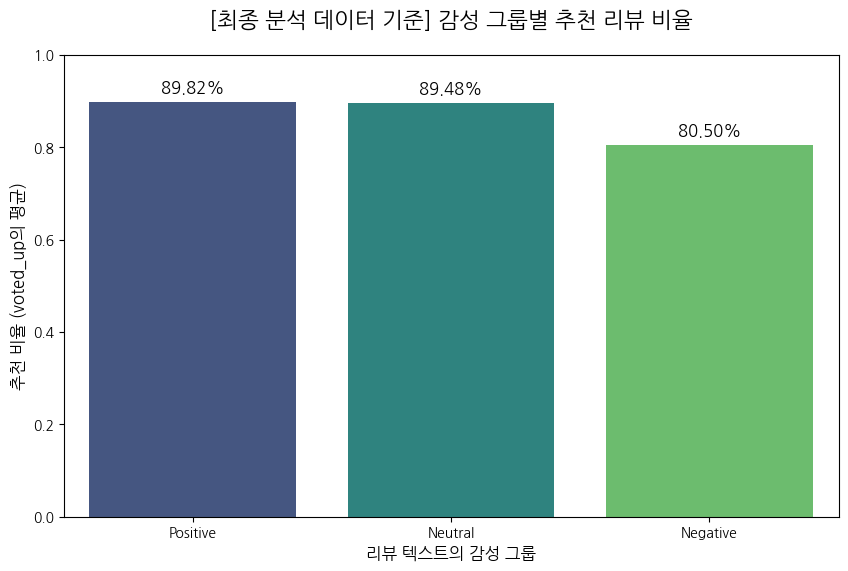

In [8]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

# =============================================================
# ✨ [분석 통일성 확보] 최종 데이터셋 기반 감성 분석 및 시각화 ✨
# =============================================================

# --- 1. 이전 단계에서 생성된 'df_english' 데이터프레임을 사용합니다 ---
# df_english 가 메모리에 없다면, 이전 코드를 실행하여 먼저 생성해주세요.

print(f"✅ 분석 대상 데이터: 영어(비한국어) 리뷰 {len(df_english)}개")

# --- 2. VADER 감성 분석 재실행 ---
vader_analyzer = SentimentIntensityAnalyzer()

def get_vader_score(text):
    if not isinstance(text, str): return 0.0
    return vader_analyzer.polarity_scores(text)['compound']

print("\nVADER 감성 점수 계산 중...")
df_english['sentiment_score'] = df_english['translated_en'].progress_apply(get_vader_score)

# 감성 그룹 분류 (기존과 동일한 기준 적용)
def assign_sentiment_group_strict(score):
    if score >= 0.05: return 'Positive'
    elif score <= -0.3: return 'Negative'
    else: return 'Neutral'

df_english['sentiment_group'] = df_english['sentiment_score'].apply(assign_sentiment_group_strict)
print("감성 그룹 분류 완료!")
print(df_english['sentiment_group'].value_counts())


# --- 3. 감성 그룹별 추천 리뷰 비율 막대그래프 재시각화 ---
sentiment_recommend_ratio = df_english.groupby('sentiment_group')['voted_up'].mean().reindex(['Positive', 'Neutral', 'Negative'])

print("\n--- [최종 데이터셋 기준] 감성 그룹별 추천(voted_up=1) 비율 ---")
print(sentiment_recommend_ratio)

plt.figure(figsize=(10, 6))
sns.barplot(x=sentiment_recommend_ratio.index, y=sentiment_recommend_ratio.values, palette='viridis')
plt.title('[최종 분석 데이터 기준] 감성 그룹별 추천 리뷰 비율', fontsize=16, pad=20)
plt.ylabel('추천 비율 (voted_up의 평균)', fontsize=12)
plt.xlabel('리뷰 텍스트의 감성 그룹', fontsize=12)
plt.ylim(0, 1)

# 막대 위에 비율 텍스트 표시
for i, val in enumerate(sentiment_recommend_ratio):
    plt.text(i, val + 0.02, f'{val:.2%}', ha='center', fontsize=12)

plt.show()